# <b>Medical Insurance - Linear Regression</b>
Анализ и предсказание расходов на мед. страхование

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

from joblib import dump

In [2]:
# Загрузка и обработка данных

df = pd.read_csv('Medical-Insurance.csv', na_values='?')
df.columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


df = df.dropna()
df['sex'] = df['sex'].astype(int)
df['smoker'] = df['smoker'].astype(int)
df['region'] = df['region'].astype(int)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,18.0,2,33.770,1,0,4,1725.55230
1,28.0,2,33.000,3,0,4,4449.46200
2,33.0,2,22.705,0,0,1,21984.47061
3,32.0,2,28.880,0,0,1,3866.85520
5,46.0,1,33.440,1,0,4,8240.58960


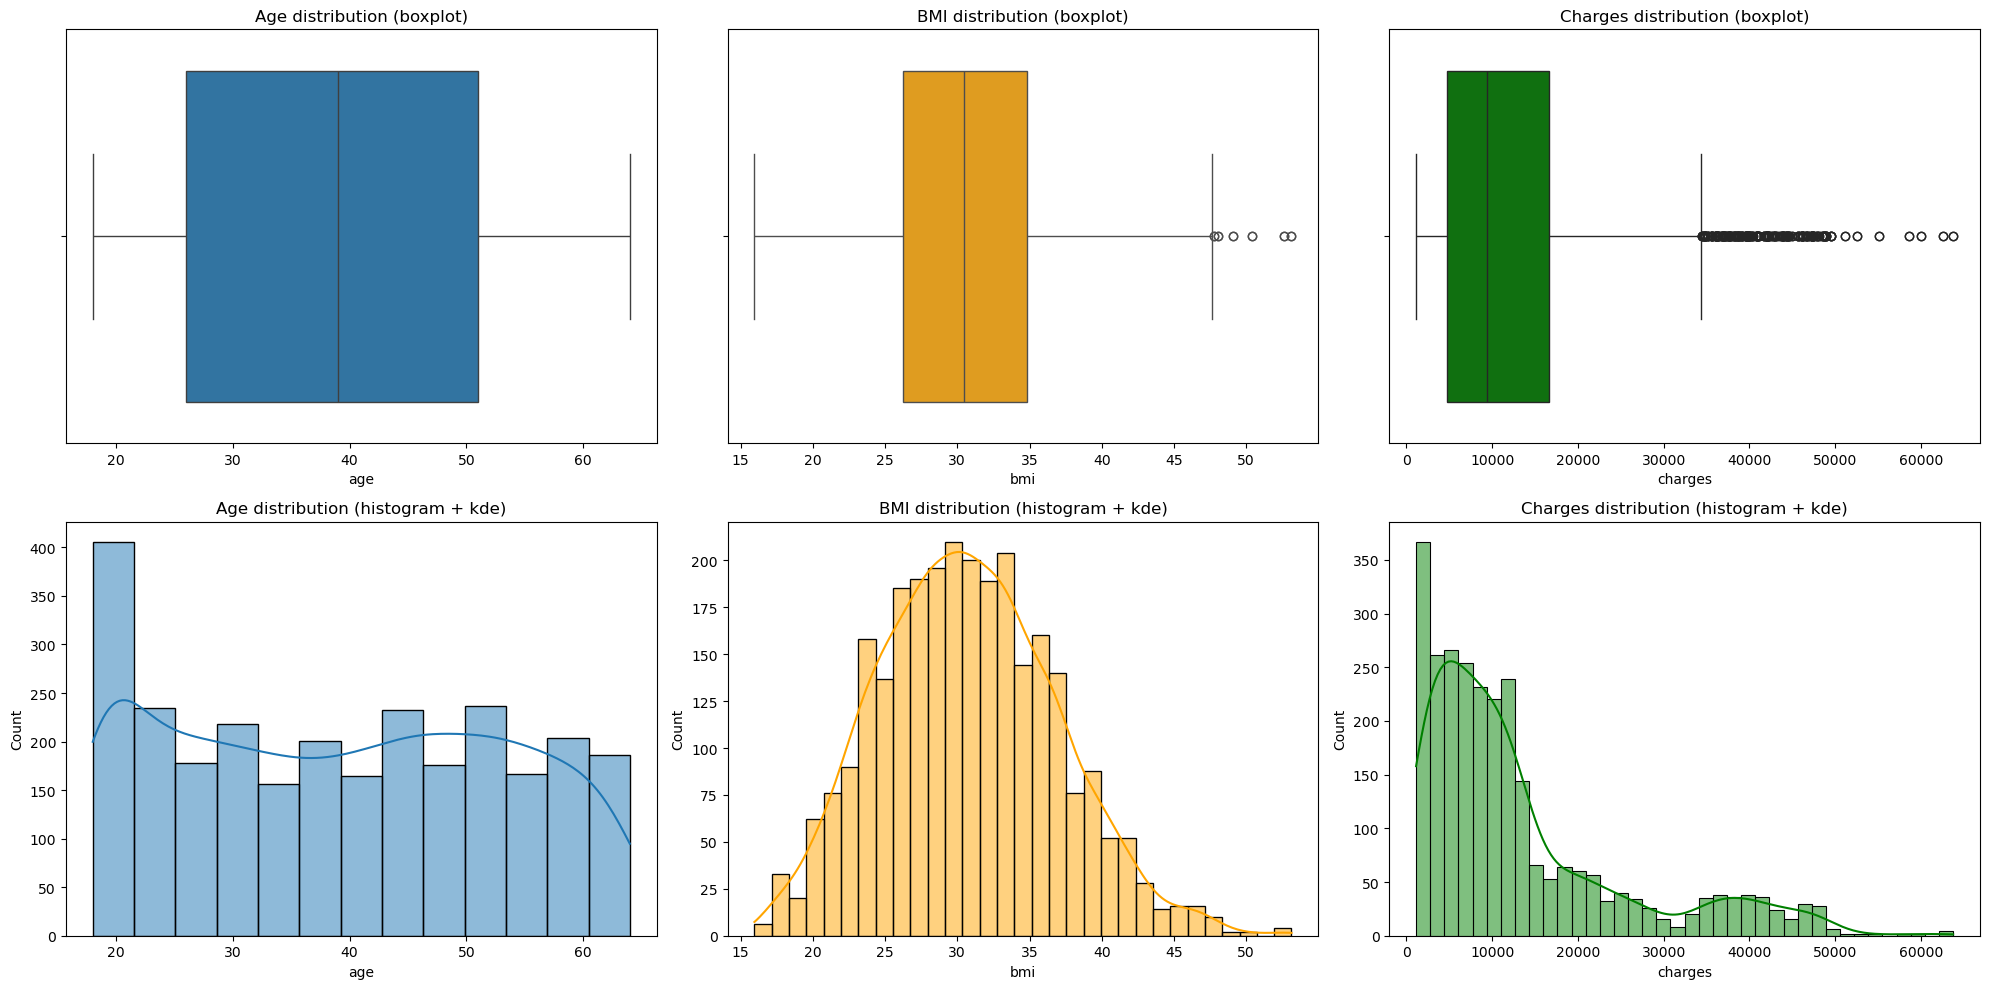

In [3]:
# Визуализация данных

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))

# age
sns.boxplot(x=df['age'], ax=ax1)
ax1.set_title('Age distribution (boxplot)')
sns.histplot(data=df['age'], kde=True, ax=ax4)
ax4.set_title('Age distribution (histogram + kde)')

# bmi
sns.boxplot(x=df['bmi'], color='orange', ax=ax2)
ax2.set_title('BMI distribution (boxplot)')
sns.histplot(data=df['bmi'], color='orange', kde=True, ax=ax5)
ax5.set_title('BMI distribution (histogram + kde)')

# charges
sns.boxplot(x=df['charges'], color='green', ax=ax3)
ax3.set_title('Charges distribution (boxplot)')
sns.histplot(data=df['charges'], color='green', kde=True, ax=ax6)
ax6.set_title('Charges distribution (histogram + kde)')

plt.tight_layout()
plt.savefig('insurance_data_visualization.png')

<b>АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПРИЗНАКОВ И ЦЕЛЕВОЙ ПЕРЕМЕННОЙ</b>

1. Распределение признака возраста показывает, что выборка охватывает диапазон от ~18 до ~65 лет. Межквартильный размах находится в пределах от ~27 до ~51 года, а медианное значение составляет около 39 лет. Выбросов по данным не наблюдается

2. Для индекса массы тела медиана составляет примерно 31, а межквартильный размах находится в диапазоне от 26 до 35. Кроме того, на этом графике можно увидеть выбросы после значения 47. Гистограмма указывает на распределение близкое к нормальному, что является хорошим фактором для последующего анализа этого признака

3. Целевая переменная (расходы на страхование) имеет ярковыраженную правостороннюю асимметрию. Медианное значение составляет около 10 000, межквартильный размах находится в пределах 5 000 - 18 000. На графике ящика с усами видно множество выбросов, превышающих 30 000 и доходящих до 60 000. Такая особенность распределения может влиять на данные при прогнозировании целевой переменной, поэтому стоит иметь это в виду

In [4]:
# Обучение модели

X = df.drop('charges', axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = ['age','bmi','children']
cat_features = ['sex','smoker','region']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), cat_features)
])

for model in [LinearRegression(), Ridge(alpha=1.0), Lasso(alpha=0.001, max_iter=10000)]:
    pipe = Pipeline([('prep', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f'{model.__class__.__name__}:', '\nRMSE:', round(rmse,2), '\nR2:', round(r2,3), '\n')

# Сохранение модели

final_model = LinearRegression()
final_model.fit(X, y)

dump(final_model, 'final_model_medinsuranse.joblib')

LinearRegression: 
RMSE: 6540.98 
R2: 0.723 

Ridge: 
RMSE: 6539.15 
R2: 0.723 

Lasso: 
RMSE: 6540.98 
R2: 0.723 



['final_model_medinsuranse.joblib']

<b>АНАЛИЗ ПОЛУЧЕННЫХ МЕТРИК</b>

1. Все три подхода работают одинаково, что указывает на устойчивость модели и отсутствие переобучения

2. R^2 имеет высокое значение, что означает высокое влияние приведенных признаков на целевую переменную

3. Значение среднеквадратической ошибки составляет приблизительно 6540 долларов. Учитывая, что расходы в нашем случае варьируются достаточно сильно, это хорошая точность предсказания


Features impact on the target variable: 

 Feature  Coefficient  Absolute Value
  smoker     24041.41        24041.41
children       497.69          497.69
  region      -334.14          334.14
     bmi       329.71          329.71
     age       254.65          254.65
     sex       -38.32           38.32


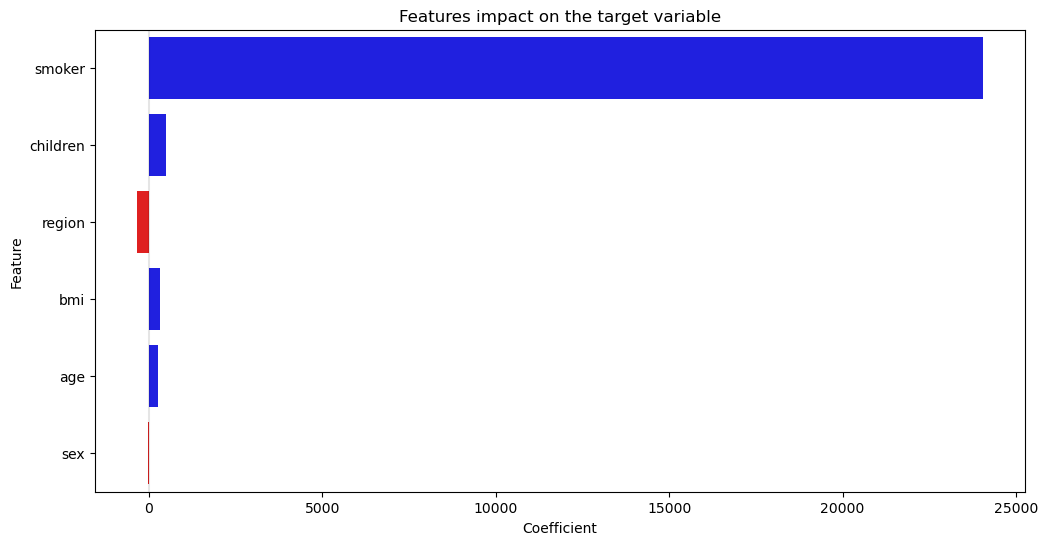

In [5]:
# Анализ коэффициентов модели

loaded_model = load('final_model_medinsuranse.joblib')

coefficients = loaded_model.coef_

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Value': abs(coefficients)
}).sort_values('Absolute Value', ascending=False)

plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'blue' for x in importance_df['Coefficient']]
sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette=colors, hue='Feature')
plt.title('Features impact on the target variable')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.1)
plt.savefig('feature_importance.png')

print("\nFeatures impact on the target variable:", '\n')
print(importance_df.round(2).to_string(index=False))

<b>АНАЛИЗ ВЛИЯНИЯ ПРИЗНАКОВ</b>

Главным фактором расходов на медицинское страхование является курение, которое значительно увеличивает затраты. Второстепенные признаки - количество детей, BMI и возраст,  тогда как пол и регион почти не влияют на результат.